**Importok és alapbeállítások**

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

2025-12-28 14:39:16.667720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766932756.844426      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766932756.899107      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766932757.316767      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766932757.316821      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766932757.316823      55 computation_placer.cc:177] computation placer alr

TF version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Path-ek beállítasa**

In [3]:
#dataset eleresi utvonala
DATASET_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray"
WEIGHTS_PATH = "/kaggle/input/keras-resnet50-weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "val")
TEST_DIR = os.path.join(DATASET_DIR, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_INITIAL = 6
EPOCHS_FINE = 6
SEED = 42

#output pathek letrehozasa(letoltheto a vegen)
OUT_ROOT = "/kaggle/working"
FIG_DIR = os.path.join(OUT_ROOT, "figures")
MET_DIR = os.path.join(OUT_ROOT, "metrics")
MODEL_DIR = os.path.join(OUT_ROOT, "models")

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(MET_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

**Adatbetöltés (augmentáció + class weight opció)**

In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.06,
    height_shift_range = 0.06,
    horizontal_flip = True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    seed = SEED
)

val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    seed = SEED
)

test_gen = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    shuffle = False
)

print("Class indices:", train_gen.class_indices)

#class weight az egyensulytalansag miatt
#kiszamoljuk a train set alapjan

counts = np.bincount(train_gen.classes)
total = counts.sum()
class_weight = {0: total/(2*counts[0]), 1: total/(2*counts[1])}
print("Train class counts:", counts, "class_weight:", class_weight)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Train class counts: [1341 3875] class_weight: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


**Modell: ResNet50 + saját head**

In [5]:
base = ResNet50(
    weights = None,
    include_top = False,
    input_tensor = Input(shape=(224, 224, 3))
)

#sulyok betoltese helyi fajlbol
base.load_weights(WEIGHTS_PATH)

#1. fazis: fagyasztas
for layer in base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
out = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base.input, outputs=out)

model.compile(
    optimizer = Adam(1e-4),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

model.summary()

I0000 00:00:1766932772.380984      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

**Callbackek (early stop, LR schedule, best checkpoint)**

In [6]:
ckpt_path = os.path.join(MODEL_DIR, "resnet50_best.keras")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, min_lr=1e-7),
    ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True)
]

**Tanítás 1.fazis (head)**

In [7]:
history1 = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = EPOCHS_INITIAL,
    callbacks = callbacks,
    class_weight = class_weight
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6


I0000 00:00:1766932784.861269     140 service.cc:152] XLA service 0x7e0dbc005770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766932784.861303     140 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766932786.741989     140 cuda_dnn.cc:529] Loaded cuDNN version 91002


  2/163 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.5547 - loss: 0.8942  

I0000 00:00:1766932790.853551     140 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 712ms/step - accuracy: 0.5226 - loss: 0.7242 - val_accuracy: 0.5000 - val_loss: 0.6747 - learning_rate: 1.0000e-04
Epoch 2/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 545ms/step - accuracy: 0.5662 - loss: 0.6741 - val_accuracy: 0.5625 - val_loss: 0.6669 - learning_rate: 1.0000e-04
Epoch 3/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 533ms/step - accuracy: 0.6859 - loss: 0.6251 - val_accuracy: 0.5625 - val_loss: 0.6364 - learning_rate: 1.0000e-04
Epoch 4/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 536ms/step - accuracy: 0.7351 - loss: 0.6086 - val_accuracy: 0.6875 - val_loss: 0.6140 - learning_rate: 1.0000e-04
Epoch 5/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 532ms/step - accuracy: 0.7629 - loss: 0.5818 - val_accuracy: 0.6250 - val_loss: 0.6090 - learning_rate: 1.0000e-04
Epoch 6/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 531ms/step - accuracy: 0.7806 - loss: 0.5589 - val_accuracy: 0.6250 - val_loss: 0.5969 - learning_rate: 1.0000e-04


**Fine-tuning 2.fázis (felső rétegek feloldása)**

In [8]:
#tipikusan a felso 30-50 reteget engedjuk tanulni
for layer in base.layers[-40:]:
    layer.trainable = True

model.compile(
    optimizer = Adam(1e-5),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

history2 = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = EPOCHS_FINE,
    callbacks = callbacks,
    class_weight = class_weight
)

Epoch 1/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 553ms/step - accuracy: 0.7765 - loss: 0.5193 - val_accuracy: 0.5000 - val_loss: 0.8763 - learning_rate: 1.0000e-05
Epoch 2/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 541ms/step - accuracy: 0.9154 - loss: 0.2092 - val_accuracy: 0.8125 - val_loss: 0.4555 - learning_rate: 1.0000e-05
Epoch 3/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 547ms/step - accuracy: 0.9196 - loss: 0.1725 - val_accuracy: 0.6875 - val_loss: 0.4194 - learning_rate: 1.0000e-05
Epoch 4/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 546ms/step - accuracy: 0.9335 - loss: 0.1710 - val_accuracy: 0.5000 - val_loss: 1.4717 - learning_rate: 1.0000e-05
Epoch 5/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 553ms/step - accuracy: 0.9411 - loss: 0.1526 - val_accuracy: 0.8750 - val_loss: 0.3616 - learning_rate: 1.0000e-05
Epoch 6/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 552ms/step - accuracy: 0.9283 - loss: 0.1704 - val_accuracy: 0.8750 - val_loss: 0.3374 - learning_rate: 1.0000e-05


**Tanulási görbék mentése**

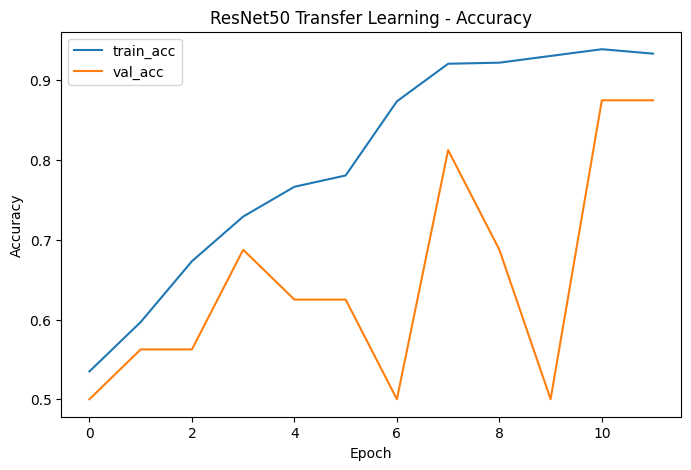

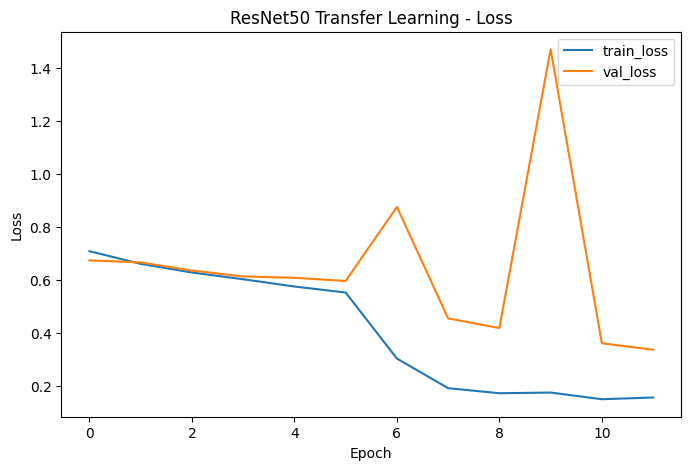

Saved: /kaggle/working/figures/resnet50_accuracy.png
Saved: /kaggle/working/figures/resnet50_loss.png


In [9]:
def merge_histories(h1, h2):
    merged = {}
    for k in h1.history.keys():
        merged[k] = h1.history[k] + h2.history[k]
    return merged

hist = merge_histories(history1, history2)

#accuracy
plt.figure(figsize=(8, 5))
plt.plot(hist["accuracy"], label="train_acc")
plt.plot(hist["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet50 Transfer Learning - Accuracy")
plt.legend()
acc_path = os.path.join(FIG_DIR, "resnet50_accuracy.png")
plt.savefig(acc_path, dpi=150, bbox_inches="tight")
plt.show()

#loss
plt.figure(figsize=(8, 5))
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet50 Transfer Learning - Loss")
plt.legend()
loss_path = os.path.join(FIG_DIR, "resnet50_loss.png")
plt.savefig(loss_path, dpi=150, bbox_inches="tight")
plt.show()

print("Saved:", acc_path)
print("Saved:", loss_path)

**Teszt kiertekeles + riport + confusion matrix + ROC**

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 492ms/step
              precision    recall  f1-score   support

      NORMAL       0.89      0.73      0.80       234
   PNEUMONIA       0.85      0.95      0.90       390

    accuracy                           0.87       624
   macro avg       0.87      0.84      0.85       624
weighted avg       0.87      0.87      0.86       624



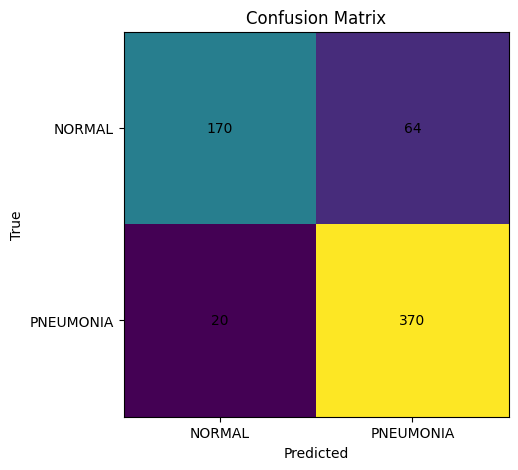

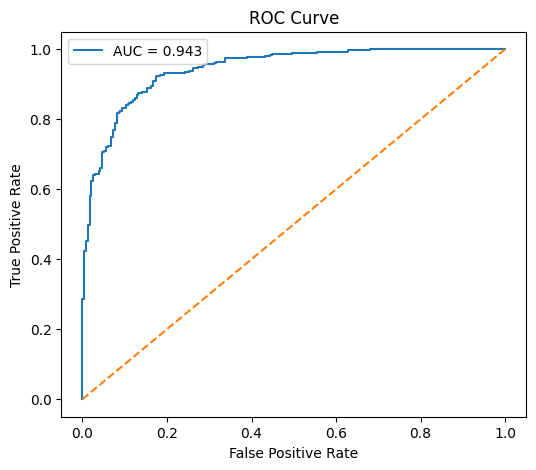

Saved: /kaggle/working/figures/resnet50_confusion_matrix.png
Saved: /kaggle/working/figures/resnet50_roc.png
Saved: /kaggle/working/metrics/resnet50_metrics.json


In [10]:
#checkpoint a legjobb
model.load_weights(ckpt_path)

test_gen.reset()
y_prob = model.predict(test_gen).ravel()
y_pred = (y_prob >= 0.5).astype(int)
y_true = test_gen.classes

#report
report = classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"], output_dict=True)
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

#confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5.5,5))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xticks([0,1], ["NORMAL", "PNEUMONIA"])
plt.yticks([0,1], ["NORMAL", "PNEUMONIA"])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
cm_path = os.path.join(FIG_DIR, "resnet50_confusion_matrix.png")
plt.savefig(cm_path, dpi=150, bbox_inches="tight")
plt.show()

#ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
roc_path = os.path.join(FIG_DIR, "resnet50_roc.png")
plt.savefig(roc_path, dpi=150, bbox_inches="tight")
plt.show()

print("Saved:", cm_path)
print("Saved:", roc_path)

#metrikak mentese JSON-ba
metrics_out = {
    "model": "ResNet50_transfer",
    "img_size": IMG_SIZE,
    "batch_size": BATCH_SIZE,
    "epochs_total": len(hist["loss"]),
    "roc_auc": float(roc_auc),
    "confusion_matrix": cm.tolist(),
    "classification_report": report
}
met_path = os.path.join(MET_DIR, "resnet50_metrics.json")
with open(met_path, "w") as f:
    json.dump(metrics_out, f, indent=2)

print("Saved:", met_path)

**Random tesztképek + helyes/hibás jelölés**

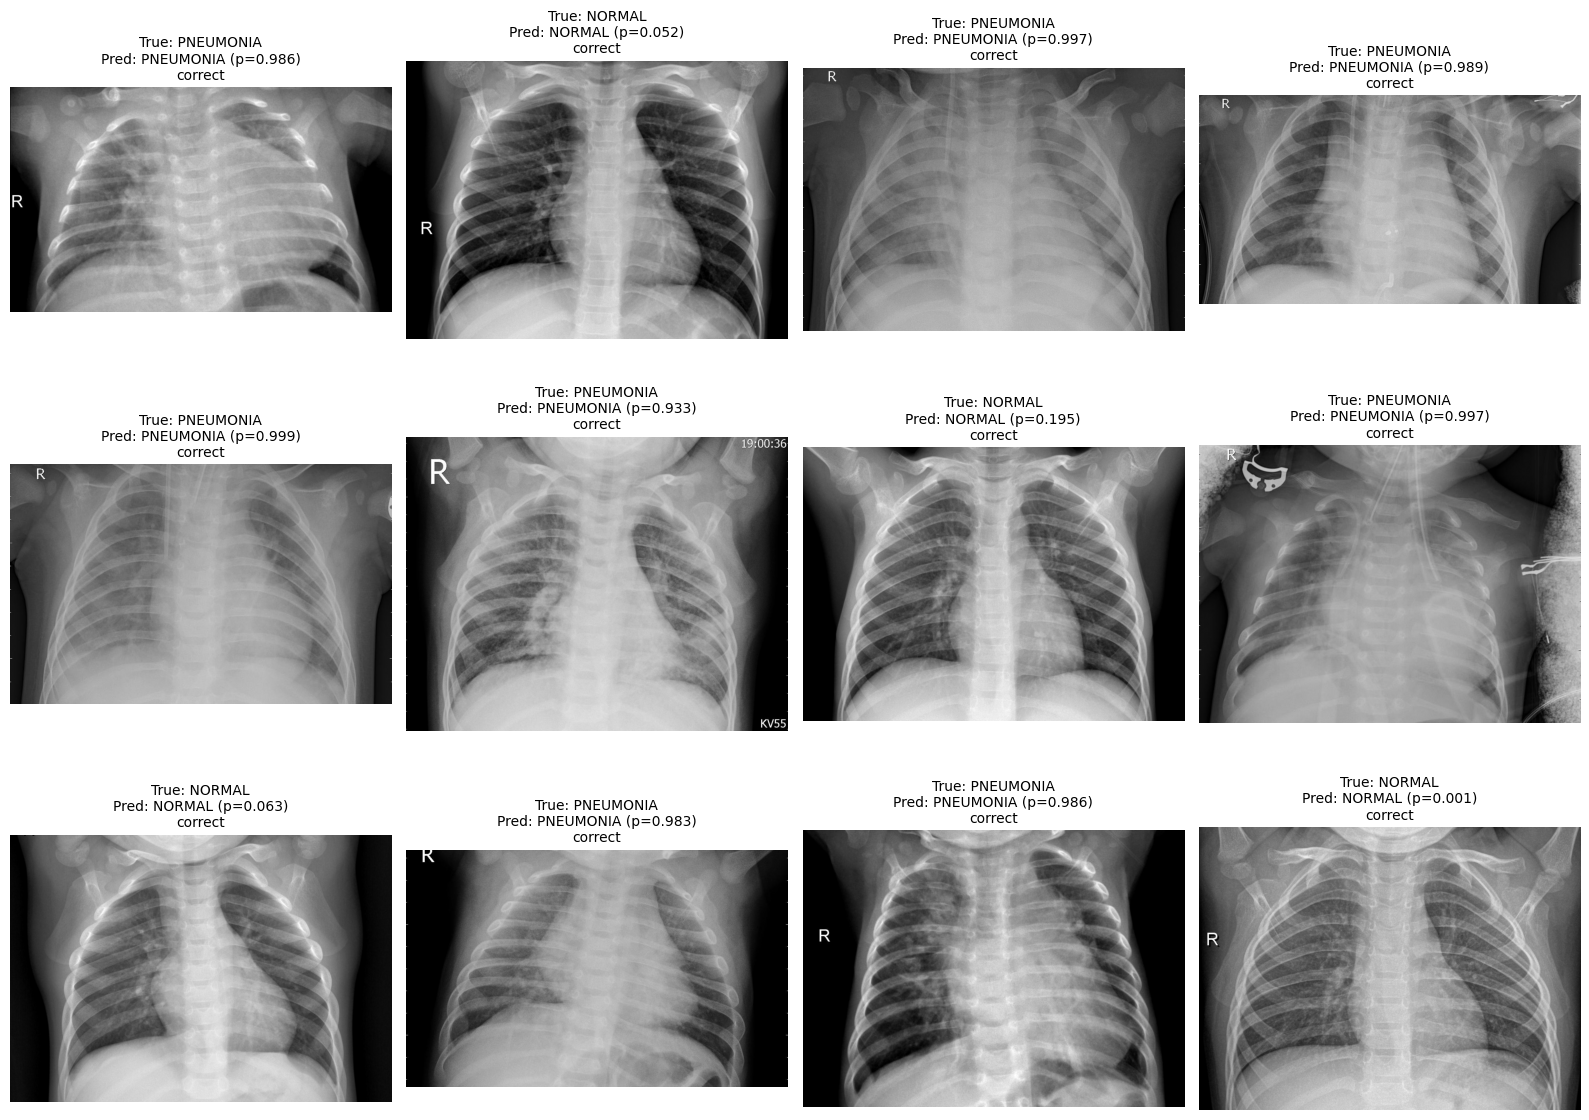

In [11]:
def show_predictions_grid(model, test_gen, n=12, threshold=0.5, seed=42):
    """
    Random minták a teszt halmazból: kép + true/pred + prob + helyes/hibás jelzés.
    Feltételezi, hogy test_gen shuffle=False.
    """
    rng = np.random.default_rng(seed)

    #predikcio a teljes teszthalmazra(egyszer)
    test_gen.reset()
    y_prob = model.predict(test_gen, verbose=0).ravel()
    y_true = test_gen.classes
    y_pred = (y_prob >= threshold).astype(int)

    #indexek kivalasztasa
    idxs = rng.choice(len(y_true), size=min(n, len(y_true)), replace=False)

    #osztalynevek
    idx_to_class = {v: k for k, v in test_gen.class_indices.items()}  # pl. {0:"NORMAL",1:"PNEUMONIA"}
    class_names = [idx_to_class[0], idx_to_class[1]]

    cols = 4
    rows = int(np.ceil(len(idxs) / cols))
    plt.figure(figsize=(cols * 4, rows * 4))

    for i, idx in enumerate(idxs, start=1):
        #kep betoltese fajlbol
        img_path = test_gen.filepaths[idx]
        img = plt.imread(img_path)

        true_label = y_true[idx]
        pred_label = y_pred[idx]
        prob = y_prob[idx]

        correct = (true_label == pred_label)
        title = (
            f"True: {class_names[true_label]}\n"
            f"Pred: {class_names[pred_label]} (p={prob:.3f})\n"
            f"{'correct' if correct else 'wrong'}"
        )

        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap="gray" if img.ndim == 2 else None)
        plt.axis("off")
        plt.title(title, fontsize=10)

    plt.tight_layout()
    plt.show()

#pelda futtatas
show_predictions_grid(model, test_gen, n=12, threshold=0.5, seed=42)

**“Legcsúnyább hibák” (amikben a modell nagyon magabiztos, mégis rossz)**

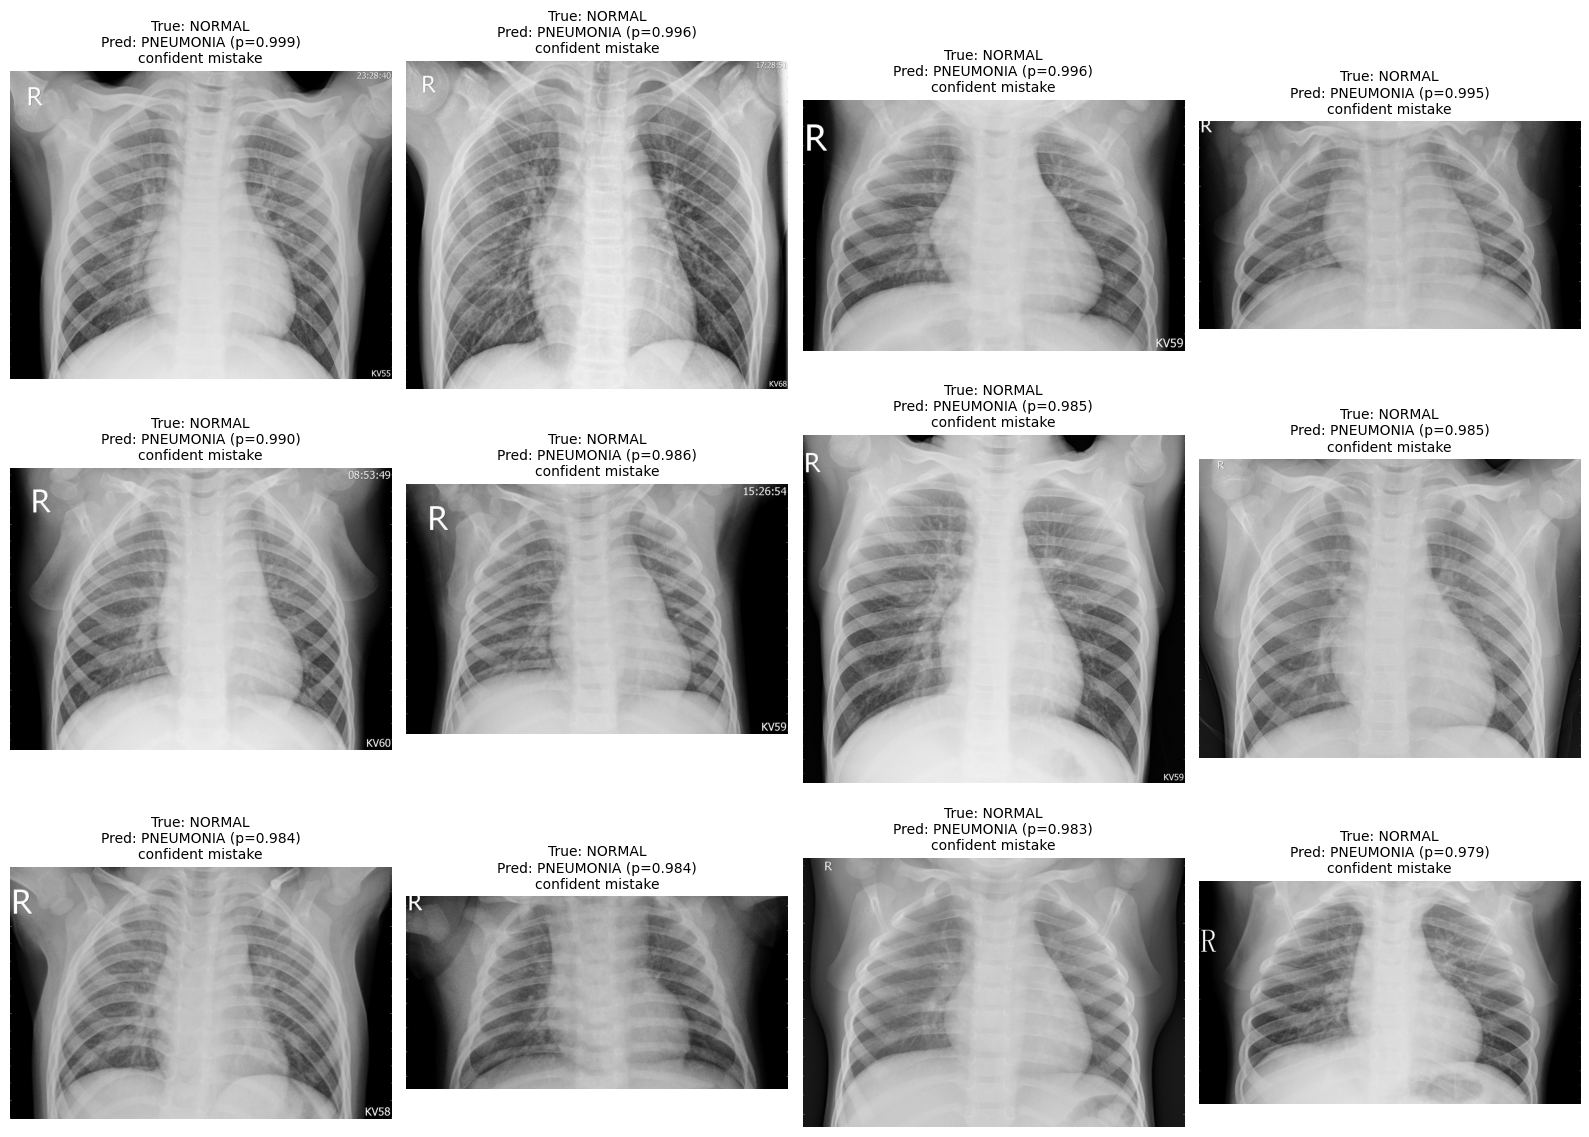

In [13]:
def show_top_mistakes(model, test_gen, k=12, threshold=0.5):
    """
    Megmutatja a k legmagabiztosabb tévedést a teszthalmazból.
    """
    test_gen.reset()
    y_prob = model.predict(test_gen, verbose=0).ravel()
    y_true = test_gen.classes
    y_pred = (y_prob >= threshold).astype(int)

    wrong = np.where(y_true != y_pred)[0]
    if len(wrong) == 0:
        print("Nincs tévesztés a teszthalmazon ezzel a threshold-dal.")
        return

    #"magabiztossag" = mennyire tavol van a 0.5-tol
    confidence = np.abs(y_prob[wrong] - threshold)
    top_wrong = wrong[np.argsort(-confidence)][:min(k, len(wrong))]

    idx_to_class = {v: k for k, v in test_gen.class_indices.items()}
    class_names = [idx_to_class[0], idx_to_class[1]]

    cols = 4
    rows = int(np.ceil(len(top_wrong) / cols))
    plt.figure(figsize=(cols * 4, rows * 4))

    for i, idx in enumerate(top_wrong, start=1):
        img_path = test_gen.filepaths[idx]
        img = plt.imread(img_path)

        true_label = y_true[idx]
        pred_label = y_pred[idx]
        prob = y_prob[idx]

        title = (
            f"True: {class_names[true_label]}\n"
            f"Pred: {class_names[pred_label]} (p={prob:.3f})\n"
            f"confident mistake"
        )

        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap="gray" if img.ndim == 2 else None)
        plt.axis("off")
        plt.title(title, fontsize=10)

    plt.tight_layout()
    plt.show()

#pelda futtatas:
show_top_mistakes(model, test_gen, k=12, threshold=0.5)

**Modell mentése**

In [12]:
final_model_path = os.path.join(MODEL_DIR, "resnet50_final.keras")
model.save(final_model_path)
print("Saved:", final_model_path)

Saved: /kaggle/working/models/resnet50_final.keras
